# Relationships using genome distance vs expression distance

In our attempt to label modules as "mostly core", "mostly accessory" or "mixed". We found that most modules were "mixed" and some were "mostly accessory". We noticed that there were many modules that had only core genes, yet were not found to be signficanlty "mostly core" based on our Fisher's exact test due to the small size of the modules as well as the large imbalance in the number of core:accessory genes.

These small modules, which are due to operons, is biologically sensible but hard for us to apply statistics. We want to try to tease apart the co-expression relationships that are due to locations (i.e. being in the same operon) versus other functional reasons.

Our strategy is the following:
* For each accessory gene, is the 1-NN/2-NN/3-NN core or accessory? Same for core genes
* For each accessory gene, is the highest correlated/2nd-highest correlated/3rd highest correlated gene core or accessory? Same for core genes.

Then we can compare the trends seen in both

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from core_acc_modules import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
offset_max = 100
offset_to_bin = 10

### Import module memberships

In [3]:
# Import module memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
pao1_membership.head()

,module id
PA0001,415
PA0002,573
PA0003,92
PA0004,567
PA0005,0


In [5]:
pa14_membership.head()

,module id
PA14_55610,3
PA14_55600,16
PA14_55590,602
PA14_55580,431
PA14_55570,46


### Map core/accessory labels to genes

In [6]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [7]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 534


In [8]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [9]:
pao1_membership.loc[pao1_core, "core/acc"] = "core"
pao1_membership.loc[pao1_acc, "core/acc"] = "acc"

In [10]:
# pa14_acc_shared = set(pa14_acc).intersection(pa14_gene_module_labels.index)
pa14_membership.loc[pa14_core, "core/acc"] = "core"
pa14_membership.loc[pa14_acc, "core/acc"] = "acc"

In [11]:
# Drop "module id" column
pao1_arr = pao1_membership.drop("module id", axis=1)
pa14_arr = pa14_membership.drop("module id", axis=1)

In [12]:
pao1_arr.head()

,core/acc
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [13]:
pa14_arr.head()

,core/acc
PA14_55610,core
PA14_55600,core
PA14_55590,core
PA14_55580,core
PA14_55570,core


## Find relationships using genome distance

In [14]:
def get_relationship_in_genome_space(core_acc_df, offset_max, offset_to_bin):
    gene_type_start = ["acc", "core"]
    gene_type_compare = ["acc", "core"]

    core_acc_df_pad = np.pad(
        core_acc_df["core/acc"], offset_max, "constant", constant_values="NA"
    )
    core_acc_df_len = len(core_acc_df)
    rows = []

    for gene_start in gene_type_start:
        for gene_compare in gene_type_compare:
            for offset in range(1, offset_max + 1):
                # Print statements to understand what is happening
                # Here we are comparing our core/....
                # print(gene_start)
                # print(gene_compare)
                # print(pao1_arr_pad[offset_max:pao1_arr_len])
                # print(pao1_arr_pad[offset_max-offset:pao1_arr_len-offset])
                counts = (
                    (core_acc_df_pad[offset_max:core_acc_df_len] == gene_start)
                    & (
                        core_acc_df_pad[offset_max - offset : core_acc_df_len - offset]
                        == gene_compare
                    )
                ).sum() + (
                    (core_acc_df_pad[offset_max:core_acc_df_len] == gene_start)
                    & (
                        core_acc_df_pad[offset_max + offset : core_acc_df_len + offset]
                        == gene_compare
                    )
                ).sum()
                rows.append(
                    {
                        "gene start": gene_start,
                        "gene compare": gene_compare,
                        "offset": offset,
                        "total": counts,
                    }
                )

    genome_dist_counts = pd.DataFrame(rows)

    # Bin distances above offset_to_bin
    long_dist = (
        genome_dist_counts.query("offset>@offset_to_bin")
        .groupby(["gene compare", "gene start"])["total"]
        .mean()
        .reset_index()
    )
    long_dist["offset"] = f"{offset_to_bin}+"
    genome_dist_counts = genome_dist_counts.query("offset<=10").append(
        long_dist, ignore_index=True
    )

    return genome_dist_counts

In [15]:
genome_dist_counts_pao1 = get_relationship_in_genome_space(
    pao1_arr, offset_max, offset_to_bin
)
genome_dist_counts_pa14 = get_relationship_in_genome_space(
    pa14_arr, offset_max, offset_to_bin
)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
genome_dist_counts_pao1.head()

,gene compare,gene start,offset,total
0,acc,acc,1,226.0
1,acc,acc,2,186.0
2,acc,acc,3,146.0
3,acc,acc,4,128.0
4,acc,acc,5,100.0


In [21]:
genome_dist_counts_pa14.head()

,gene compare,gene start,offset,total
0,acc,acc,1,696.0
1,acc,acc,2,626.0
2,acc,acc,3,586.0
3,acc,acc,4,546.0
4,acc,acc,5,508.0


### Plot

Text(0.5, 0, 'Offset in genome space')

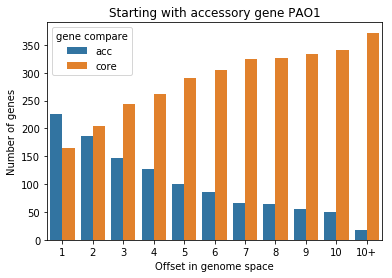

In [16]:
sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
)
plt.title("Starting with accessory gene PAO1")
plt.ylabel("Number of genes")
plt.xlabel("Offset in genome space")

Text(0.5, 0, 'Offset in genome space')

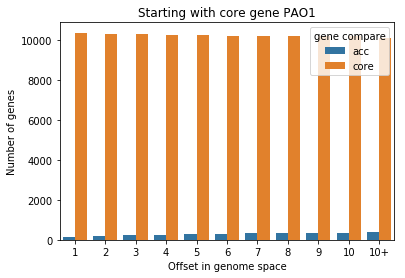

In [17]:
sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
)
plt.title("Starting with core gene PAO1")
plt.ylabel("Number of genes")
plt.xlabel("Offset in genome space")

Text(0.5, 0, 'Offset in genome space')

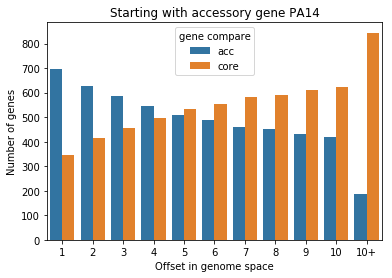

In [18]:
sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
)
plt.title("Starting with accessory gene PA14")
plt.ylabel("Number of genes")
plt.xlabel("Offset in genome space")

Text(0.5, 0, 'Offset in genome space')

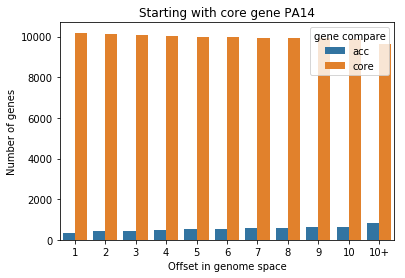

In [19]:
sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
)
plt.title("Starting with core gene PA14")
plt.ylabel("Number of genes")
plt.xlabel("Offset in genome space")

**Takeaway:**
* Accessory genes are clustered together on the genome, which is known.
* Starting with a core gene, at any distance you find many core genes because there are so many core genes